<a href="https://colab.research.google.com/github/KhizarJamshaidIqbal/MobileNet/blob/main/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import All NecessaryPackages**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
import os
import cv2
import numpy as np
from keras.preprocessing import image
from PIL import Image
from tensorflow import lite
#from tensorflow.keras.models import load_model

# **Extract the Data from our Kaggle Pakistan Curency DataSet**




In [ ]:
# Dataset - https://www.kaggle.com/datasets/khizarjamshaid/pakistan-currency-dataset
# Dataset - https://www.kaggle.com/datasets/khizarjamshaid/new-pakistani-currency-note-dataset
# Dataset - https://www.kaggle.com/datasets/khizarjamshaid/newstyle-pakistan2

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#!kaggle datasets download -d salader
!kaggle datasets download -d khizarjamshaid/newstyle-pakistan2

Dataset URL: https://www.kaggle.com/datasets/khizarjamshaid/newstyle-pakistan2
License(s): other
100% 6.50G/6.50G [00:33<00:00, 168MB/s]
100% 6.50G/6.50G [00:33<00:00, 211MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/newstyle-pakistan2.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Connect With the GoogleDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Preprocessing the Data**

In [ ]:
from glob import glob

# Image size
IMAGE_SIZE = [224, 224]

# Paths to training and validation data
train_path = '/content/NewStyle_Pakistan/Training'
valid_path = '/content/NewStyle_Pakistan/Valid'

# Load MobileNet model with pre-trained weights, excluding the top layers
vgg = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze all VGG16 layers
for layer in vgg.layers:
    layer.trainable = False

# Get number of classes
folders = glob('/content/NewStyle_Pakistan/Training/*')
print(folders)

# Add custom layers on top of VGG16
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# Create the model
model = Model(inputs=vgg.input, outputs=prediction)

# View the model structure
model.summary()

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ImageDataGenerator with various augmentation techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with augmentation
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

# Load validation data without augmentation
test_set = test_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

17225924/17225924 [==============================] - 0s 0us/step
['/content/NewStyle_Pakistan/Training/1000Rs', '/content/NewStyle_Pakistan/Training/others', '/content/NewStyle_Pakistan/Training/5000Rs', '/content/NewStyle_Pakistan/Training/500Rs', '/content/NewStyle_Pakistan/Training/50Rs', '/content/NewStyle_Pakistan/Training/10Rs', '/content/NewStyle_Pakistan/Training/20Rs', '/content/NewStyle_Pakistan/Training/100Rs']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                               

# **Run epochs**

In [ ]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-10-051908e78a64>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/15
219/219 [==============================] - 275s 1s/step - loss: 4.3619 - accuracy: 0.5557 - val_loss: 2.3638 - val_accuracy: 0.8393
Epoch 2/15
219/219 [==============================] - 280s 1s/step - loss: 3.1380 - accuracy: 0.7027 - val_loss: 2.8233 - val_accuracy: 0.7746
Epoch 3/15
219/219 [==============================] - 280s 1s/step - loss: 3.3182 - accuracy: 0.7263 - val_loss: 3.6459 - val_accuracy: 0.7698
Epoch 4/15
219/219 [==============================] - 272s 1s/step - loss: 3.2359 - accuracy: 0.7554 - val_loss: 1.6437 - val_accuracy: 0.8873
Epoch 5/15
219/219 [==============================] - 263s 1s/step - loss: 2.9414 - accuracy: 0.7866 - val_loss: 1.2350 - val_accuracy: 0.9065
Epoch 6/15
219/219 [==============================] - 275s 1s/step - loss: 2.9802 - accuracy: 0.7914 - val_loss: 2.6830 - val_accuracy: 0.8201
Epoch 7/15
219/219 [==============================] - 277s 1s/step - loss: 3.1663 - accuracy: 0.7923 - val_loss: 2.3887 - val_accuracy: 0.8561

# **Loss Graph**

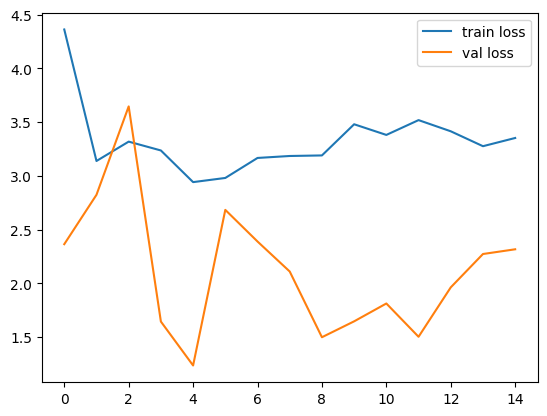

In [ ]:
## loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

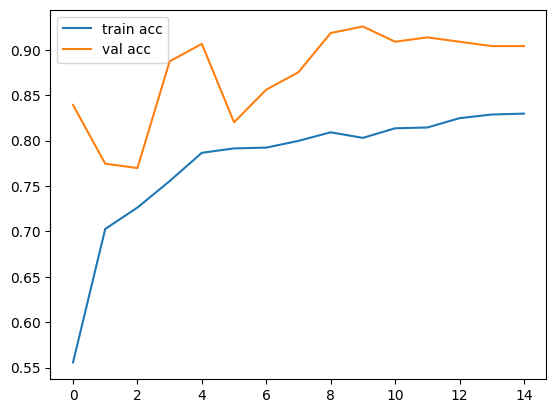

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')  # Corrected key
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# **Saved Model**

In [ ]:
# model.save('/content/gdrive/MyDrive/Models/VGG16/VGG16_AC_69/VGG16.h5')
model_save_path = '/content/gdrive/MyDrive/pcsd/Saved_Model/MobileNet.h5'
model.save(model_save_path)
print('Your Model is==> ',os.getcwd())
# Confirm the save path
print(f"Model saved successfully at: {model_save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Your Model is==>  /content
Model saved successfully at: /content/gdrive/MyDrive/pcsd/Saved_Model/MobileNet.h5


# **Testing The Model**

['1000Rs', '100Rs', '10Rs', '20Rs', '5000Rs', '500Rs', '50Rs', 'others']
1/1 [==============================] - 0s 442ms/step


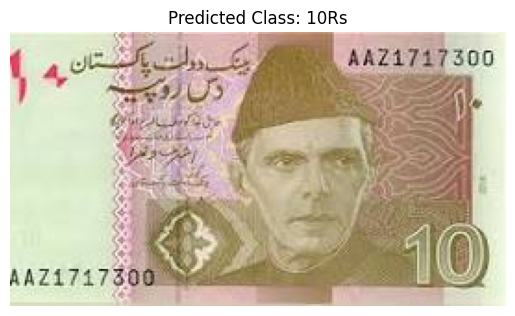

In [ ]:
# Load the trained model
model_path = model_save_path
# Update with the actual path to your saved model
loaded_model = load_model(model_path)


# Get the class names
class_names = sorted(training_set.class_indices.keys())
print(class_names)


# Specify the path to the test image
test_img_path = '/content/download.jpg'
# test_img_path = '/content/images.jpg'


# Function to preprocess an image
def preprocess_img(img_path):
    img = Image.open(img_path)  # Use PIL to open the image
    img = img.resize((224, 224))  # Resize the image
    img_array = np.array(img)  # Convert PIL image to NumPy array
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Function to predict the class of an image
def predict_class(img_path):
    img = preprocess_img(img_path)
    prediction = loaded_model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Predict the class for the test image
predicted_class = predict_class(test_img_path)

# Display the test image and predicted class
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


# **Saved**

**TFLite Tensorflow Model**

In [ ]:
# Load the Keras model
model = load_model(model_save_path)

# Convert the model to TensorFlow Lite format
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('/content/gdrive/MyDrive/pcsd/Saved_Model/MobileNet.tflite', 'wb') as f:
    f.write(tflite_model)

**labels.txt**

In [ ]:
# Replace this list with your actual class labels
class_labels = class_names

# Save the class labels to a file
with open("labels.txt", "w") as file:
    for label in class_labels:
        file.write(label + "\n")

# Move the file to the desired directory
import shutil
shutil.move("labels.txt", "/content/gdrive/MyDrive/pcsd/Saved_Model/MobileNet/")
